In [85]:
import torch, yaml
import numpy as np
import matplotlib.pyplot as plt
import bsde.metrics

import importlib
importlib.reload(bsde.metrics)

from pathlib import Path

from bsde.solver import BSDESolver
from bsde.payoff import lookback_max
from bsde.metrics import delta_hedge, dv_hedge


cfg = yaml.safe_load(Path("experiments/config.yaml").read_text())

In [86]:
payoff_func = lambda S: lookback_max(S, strike=cfg["payoff"]["K"])


net_cfg = dict(hidden=128, depth=4)

In [78]:
solver = BSDESolver(
    model_params=cfg["model"],
    payoff_fn=payoff_func,
    T=cfg["T"],
    n_steps=cfg["n_steps"],
    net_cfg=net_cfg,
    lr=1e-4,
)

In [87]:
solver.net.load_state_dict(torch.load("mod/bsde_lookback.pt",map_location="cpu"))
solver.net.eval()

FeedForwardNN(
  (fcn): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
  )
  (y_head): Linear(in_features=128, out_features=1, bias=True)
  (z_head): Linear(in_features=128, out_features=2, bias=True)
)

Y0 net  :, 0.15299080312252045, should be : MC Price = 0.13
Delta net :, 0.017989158630371094, should be : << 1

payoff  mean : 0.15702378749847412
payoff  max  : 0.715416669845581    payoff min : 0.0
cash0  mean  : 0.14888200163841248
pos0   mean  : 0.005617604125291109


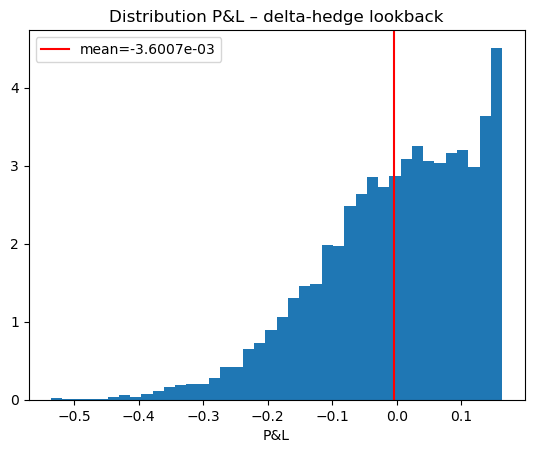

 mean  : -0.0036006623413413763
 stdev : 0.11821181327104568


In [82]:
pnl = delta_hedge(
    simulator =solver.simulator,
    net       = solver.net,      
    payoff_fn = payoff_func,
    n_paths   = 10_000,             # assez pour voir la distribution
    n_steps   = cfg["n_steps"],
    T         = cfg["T"]
)

plt.hist(pnl, bins=40, density=True)
plt.axvline(pnl.mean(), color="r", label=f"mean={pnl.mean():.4e}")
plt.title("Distribution P&L – delta-hedge lookback")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl.mean().item())
print(" stdev :", pnl.std().item())

In [90]:
pnl_dv = dv_hedge(simulator=solver.simulator,
               net=solver.net,
               payoff_fn=payoff_func,
               n_paths=20_000,
               n_steps=cfg["n_steps"],
               T=cfg["T"])
print("Δ-only  σ ≈", pnl.std().item())
print("Δ+V     σ ≈", pnl_dv.std().item())

Δ-only  σ ≈ 0.11821181327104568
Δ+V     σ ≈ 0.10880252718925476


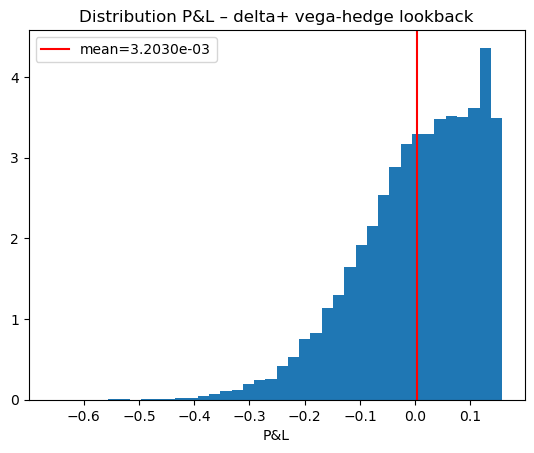

 mean  : 0.003203046042472124
 stdev : 0.10880252718925476


In [91]:
plt.hist(pnl_dv, bins=40, density=True)
plt.axvline(pnl_dv.mean(), color="r", label=f"mean={pnl_dv.mean():.4e}")
plt.title("Distribution P&L – delta+ vega-hedge lookback")
plt.xlabel("P&L"); plt.legend(); plt.show()

print(" mean  :", pnl_dv.mean().item())
print(" stdev :", pnl_dv.std().item())